In [1]:
%%time
# Step 1: GPU configuration
!nvidia-smi


Sun Dec 31 22:36:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 3: Install required packages
!pip install tensorflow_addons
!pip install visualkeras
!pip install -U tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.4 MB/s eta 0:00:00


In [4]:
# Step 4: Import libraries
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

import warnings
import pandas as pd
from sklearn.utils import class_weight
from collections import Counter

warnings.filterwarnings('ignore')
%matplotlib inline


In [5]:
# Step 5: Define labels and image size
labels = ["Cucumber Mosaic Virus", "Downy Mildew", "Leaf Spot"]
img_size = 32


In [6]:
# Step 6: Function to get data
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [7]:
# Step 7: Load data
data_dir = get_data("/content/drive/MyDrive/Luffa Aegyptiaca 480")

In [8]:
# Step 8: Display total number of training images
image_names = glob.glob(os.path.join('/content/drive/MyDrive/Luffa Aegyptiaca 480', '*', '*'))
print("Total number of training images: ", len(image_names))


Total number of training images:  6533


In [9]:
# Step 9: Create a DataFrame with Filename and ClassId
data_df = pd.DataFrame()
data_df['Filename'] = [img_name.split("/")[-1] for img_name in image_names]
data_df['ClassId'] = [img_name.split("/")[-2] for img_name in image_names]


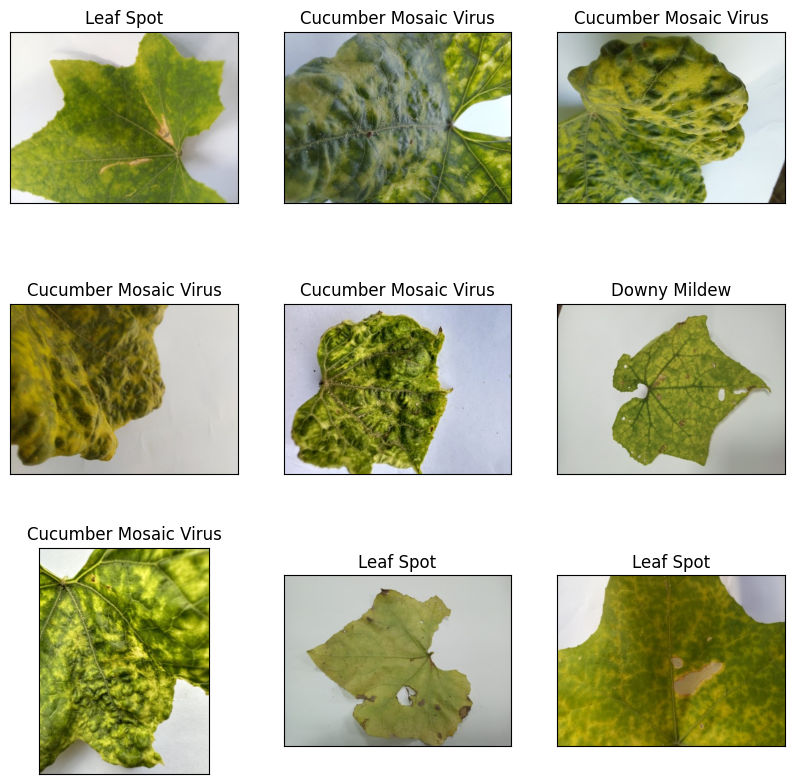

In [10]:
# Step 10: Display sample images
plot_df = data_df.sample(min(9, len(data_df))).reset_index()
plt.figure(figsize=(10, 10))
for i in range(9):
    img_name = plot_df.loc[i, 'Filename']
    label_str = (plot_df.loc[i, 'ClassId'])
    plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread(os.path.join('/content/drive/MyDrive/Luffa Aegyptiaca 480', label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])


<BarContainer object of 3 artists>

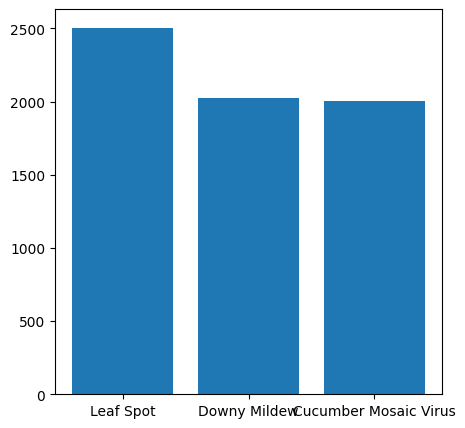

In [11]:
# Step 11: Display class distribution
class_id_distribution = data_df['ClassId'].value_counts()
plt.figure(figsize=(5,5))
plt.xticks(np.arange(43))
plt.bar(class_id_distribution.index, class_id_distribution.values)


In [12]:
# Step 12: Preprocess and split data
X = []
Y = []
for feature, label in data_dir:
    X.append(feature)
    Y.append(label)
X = np.array(X) / 255
X = X.reshape(-1, img_size, img_size, 3)  # Assuming color images, adjust channels if grayscale
Y = np.array(Y)

# Step 12a: Add k-fold cross-validation
from sklearn.model_selection import StratifiedKFold

# Assuming you have defined create_cnn_classifier() function
def create_cnn_classifier():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        MaxPool2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPool2D(2, 2),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPool2D(2, 2),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Set up k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [13]:
# Step 13: Split data with stratified sampling
from sklearn.model_selection import train_test_split

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.10, stratify=Y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.18, random_state=8)


In [14]:
# Step 14: Display shapes of train, validation, and test sets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (4820, 32, 32, 3) - y_train shape: (4820,)
x_val shape: (1059, 32, 32, 3) - y_val shape: (1059,)
x_test shape: (654, 32, 32, 3) - y_test shape: (654,)


In [15]:
# Step 16: Set up model parameters
num_classes = 3
input_shape = (32, 32, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 250


In [16]:
# Step 17: Data augmentation
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(img_size, img_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)


In [17]:
# Step 18: Define CNN model
def create_cnn_classifier():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPool2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPool2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPool2D(2,2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [18]:
# Step 19: Display CNN model summary
cnn_classifier = create_cnn_classifier()
cnn_classifier.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [19]:
# Step 20: Compile CNN model
initial_learning_rate = learning_rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=weight_decay, staircase=True
)

cnn_classifier.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
# Step 21: Run CNN experiment with k-fold cross-validation
from keras.callbacks import EarlyStopping

# Run CNN experiment with k-fold cross-validation
cnn_history_list = []  # List to store histories for each fold
test_accuracies = []  # List to store test accuracies for each fold

for fold_index, (train_indices, val_indices) in enumerate(kfold.split(X, Y)):
    print(f"\nTraining for fold {fold_index + 1}...\n")

    x_train_fold, x_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = Y[train_indices], Y[val_indices]

    # Create and compile model for each fold
    cnn_classifier = create_cnn_classifier()
    cnn_classifier.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model for each fold
    history = cnn_classifier.fit(
        x_train_fold, y_train_fold,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping_cnn]
    )

    # Save history for later analysis
    cnn_history_list.append(history)

    # Evaluate on test set
    test_loss, test_accuracy = cnn_classifier.evaluate(x_test, y_test)
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy for Fold {fold_index + 1}: {test_accuracy:.4f}")

# Analyze or visualize results using cnn_history_list and test_accuracies



Training for fold 1...

Epoch 1/250
41/41 [==============================] - 6s 23ms/step - loss: 0.8432 - accuracy: 0.6137 - val_loss: 0.4492 - val_accuracy: 0.8340
Epoch 2/250
41/41 [==============================] - 0s 7ms/step - loss: 0.4553 - accuracy: 0.8209 - val_loss: 0.3042 - val_accuracy: 0.8952
Epoch 3/250
41/41 [==============================] - 0s 7ms/step - loss: 0.3104 - accuracy: 0.8733 - val_loss: 0.2025 - val_accuracy: 0.9403
Epoch 4/250
41/41 [==============================] - 0s 7ms/step - loss: 0.2151 - accuracy: 0.9160 - val_loss: 0.1368 - val_accuracy: 0.9610
Epoch 5/250
41/41 [==============================] - 0s 8ms/step - loss: 0.1545 - accuracy: 0.9447 - val_loss: 0.1059 - val_accuracy: 0.9686
Epoch 6/250
41/41 [==============================] - 0s 7ms/step - loss: 0.1244 - accuracy: 0.9564 - val_loss: 0.0924 - val_accuracy: 0.9725
Epoch 7/250
41/41 [==============================] - 0s 8ms/step - loss: 0.0921 - accuracy: 0.9684 - val_loss: 0.0823 - val_accu

In [ ]:
# Analyzing training history for each fold
for fold_index, history in enumerate(cnn_history_list):
    print(f"\nFold {fold_index + 1} Metrics:")
    print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")


In [ ]:
# Visualizing training and validation metrics for each fold
plt.figure(figsize=(12, 8))

for fold_index, history in enumerate(cnn_history_list):
    plt.subplot(2, 2, fold_index + 1)
    plt.plot(history.history['accuracy'], label=f'Train Fold {fold_index + 1}')
    plt.plot(history.history['val_accuracy'], label=f'Validation Fold {fold_index + 1}')
    plt.title(f'Fold {fold_index + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Calculating average metrics across all folds
avg_train_accuracy = np.mean([history.history['accuracy'][-1] for history in cnn_history_list])
avg_val_accuracy = np.mean([history.history['val_accuracy'][-1] for history in cnn_history_list])
avg_train_loss = np.mean([history.history['loss'][-1] for history in cnn_history_list])
avg_val_loss = np.mean([history.history['val_loss'][-1] for history in cnn_history_list])

print(f"\nAverage Metrics Across All Folds:")
print(f"Average Training Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")


In [ ]:
# Step 23: Plot training and validation metrics
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Step 24: Evaluate CNN model on validation set
cnn_predictions = cnn_classifier.predict(x_val)
cnn_y_pred = [np.argmax(probas) for probas in cnn_predictions]


In [ ]:
# Step 25: Plot normalized confusion matrix for validation set
from sklearn.metrics import confusion_matrix

# Compute confusion matrix for validation set
cnf_matrix_cnn = confusion_matrix(y_val, cnn_y_pred)

# Plot confusion matrix for validation set based on support
plt.figure()
plot_confusion_matrix_support(cnf_matrix_cnn, classes=labels, title='Confusion matrix (CNN - Validation)')
plt.show()


In [ ]:
# Step 26: Display classification report for validation set
print(classification_report(y_val, cnn_y_pred, target_names=labels))


In [ ]:
# Step 27: Evaluate CNN model on test set
cnn_predictions_test = cnn_classifier.predict(x_test)
cnn_y_pred_test = [np.argmax(probas) for probas in cnn_predictions_test]


In [ ]:
# Step 28: Plot normalized confusion matrix for test set
# Compute confusion matrix for test set
cnf_matrix_cnn_test = confusion_matrix(y_test, cnn_y_pred_test)

# Plot confusion matrix for test set based on support
plt.figure()
plot_confusion_matrix_support(cnf_matrix_cnn_test, classes=labels, title='Confusion matrix (CNN - Test)')
plt.show()
